In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

# Setting Up Pandas

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Read File

In [3]:
# Read .csv file:
df_ = pd.read_excel("OnlineRetail.xlsx",
                    sheet_name="Online Retail")
df = df_.copy()
df.shape

(541909, 8)

# Data Pre Processing

In [4]:
##### Data Preparation:
# First look at the data, drop null observations,
# drop negative invoice observations,
# Drop quantity observations that are < 0

df.describe().T
df.dropna(inplace=True)
df.isnull().sum()
df = df[~df["InvoiceNo"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


# Outliers For Datasets

In [5]:
##### Accessing and Suppressing Outliers:

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity") 
replace_with_thresholds(df, "UnitPrice")
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397924.0000,11.8337,1.0000,2.0000,6.0000,12.0000,298.5000,25.5345
InvoiceDate,397924,2011-07-10 23:43:36.912475648,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
UnitPrice,397924.0000,2.8932,0.0000,1.2500,1.9500,3.7500,37.0600,3.2271
CustomerID,397924.0000,15294.3152,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1699


# Model Prep

##### 1. BGNBD MODEL

In [6]:
###### BGNBD MODEL PREPARATION:

# recency represents the age of the customer when they made their most recent purchases. / weekly
# This is equal to the duration between a customer’s first purchase and their latest purchase.
# T: Customer's age. Weekly. (Calculated upon the date of first transaction of the customer.)
# frequency: Number of repatative transactions (frequency>1)
# monetary_value: Average profit per purchase

# Let's choose a region: UK!
df = df[df["Country"] == "United Kingdom"]
df.head()
df.shape
df["Country"].nunique()

1

In [7]:
# Data Preparation for BGNBD
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

cltv_df = df.groupby("CustomerID").agg({"InvoiceDate": [lambda date: ((date.max() - date.min()).days) / 7,
                                                         lambda date: ((today_date - date.min()).days) / 7],
                                         "InvoiceNo": lambda freq: freq.nunique(),
                                         "TotalPrice": lambda TotalPrice: TotalPrice.sum()})
cltv_df.head()
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary_value"]

In [8]:
# Expressing monetary value as average profit per purchase
cltv_df["monetary_value"] = cltv_df["monetary_value"] / cltv_df["frequency"]

# Choosing monetary values greater than zero
cltv_df = cltv_df[cltv_df["monetary_value"] > 0]

# frequency must be greater than 1.
cltv_df = cltv_df[(cltv_df["frequency"] > 1)]
cltv_df.describe().T
(cltv_df["frequency"]<1).value_counts()


frequency
False    2570
Name: count, dtype: int64

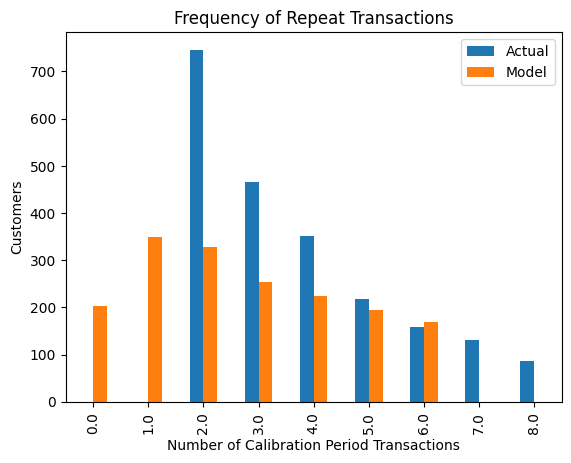

In [9]:
####### BGNBD MODEL:

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

plot_period_transactions(bgf)
plt.show()

In [10]:
# Ex: the 10 customers we expect the most to purchase in a week:

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df["frequency"],
                                              cltv_df["recency"],
                                              cltv_df["T"])

cltv_df.head()
cltv_df.sort_values(by="expected_purc_1_week", ascending=False).head(10)

,recency,T,frequency,monetary_value,expected_purc_1_week
CustomerID,,,,,
12748.0000,53.1429,53.4286,210,154.1924,3.2530
17841.0000,53.0000,53.4286,124,330.1344,1.9333
13089.0000,52.2857,52.8571,97,606.3625,1.5320
14606.0000,53.1429,53.4286,93,130.1390,1.4588
15311.0000,53.2857,53.4286,91,667.7791,1.4286
12971.0000,52.5714,53.2857,86,127.4859,1.3523
13408.0000,53.0000,53.4286,62,453.5006,0.9829
18102.0000,52.2857,52.5714,60,3859.7391,0.9653
13798.0000,52.8571,53.2857,57,650.9085,0.9082


##### 2. GAMMA GAMMA MODEL:

In [11]:
###### GAMMA GAMMA MODEL:

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df["frequency"], cltv_df["monetary_value"])

cltv_df["exp_avg_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                                                    cltv_df["monetary_value"])

cltv_df.sort_values("exp_avg_profit", ascending=False)

,recency,T,frequency,monetary_value,expected_purc_1_week,exp_avg_profit
CustomerID,,,,,,
14088.0000,44.5714,46.1429,13,3864.5546,0.2597,3916.3832
18102.0000,52.2857,52.5714,60,3859.7391,0.9653,3870.8387
15749.0000,13.8571,47.5714,3,3028.7800,0.0284,3213.2739
14096.0000,13.8571,14.5714,17,3163.5882,0.7231,3195.9719
17511.0000,52.8571,53.4286,31,2933.9431,0.5074,2950.3463
...,...,...,...,...,...,...
17988.0000,44.8571,46.7143,7,28.3186,0.1548,29.5769
15516.0000,0.1429,6.7143,3,20.8100,0.2242,23.3936
18037.0000,29.5714,51.8571,6,11.6700,0.0837,12.6556


# Model Evaluatioon

In [12]:
###################
#  Finally! Calculation of CLTV with BG-NBD and GG model.
###################

# Ex: For 6 months of time prediction

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary_value"],
                                   time=12,
                                   freq="W",
                                   discount_rate=0.01)

cltv = cltv.reset_index()

cltv_final = cltv_df.merge(cltv, on="CustomerID", how="left")

# Final Table

In [13]:
# Let's see the final table:

cltv_final.sort_values(by="clv", ascending=False).head(10)

,CustomerID,recency,T,frequency,monetary_value,expected_purc_1_week,exp_avg_profit,clv
2486,18102.0000,52.2857,52.5714,60,3859.7391,0.9653,3870.8387,176133.7843
589,14096.0000,13.8571,14.5714,17,3163.5882,0.7231,3195.9719,105051.1555
2184,17450.0000,51.2857,52.5714,46,2863.2749,0.7451,2874.0455,100934.1543
2213,17511.0000,52.8571,53.4286,31,2933.9431,0.5074,2950.3463,70574.4182
1804,16684.0000,50.4286,51.2857,28,2209.9691,0.4767,2223.6899,49921.7792
406,13694.0000,52.7143,53.4286,50,1275.7005,0.7983,1280.1557,48186.9705
587,14088.0000,44.5714,46.1429,13,3864.5546,0.2597,3916.3832,47750.6104
1173,15311.0000,53.2857,53.4286,91,667.7791,1.4286,669.0782,45080.1888
1485,16000.0000,0.0000,0.4286,3,2335.1200,0.4160,2477.6641,44568.9037
133,13089.0000,52.2857,52.8571,97,606.3625,1.5320,607.4725,43880.6286


# Segmentation For Customer

In [14]:
###### Segmentation of Customers:

# 1. Scaling for better insight of dataframe:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

# 2. Segmentation:
cltv_final["Segment"] = pd.qcut(cltv_final["scaled_clv"], 4, ["D", "C", "B", "A"])
cltv_final.head()

cltv_final.groupby("Segment").agg(["count", "mean", "sum"])

CustomerID                          recency                        T                    frequency               monetary_value                      expected_purc_1_week                 exp_avg_profit                        clv                        scaled_clv               
             count       mean           sum   count    mean        sum count    mean        sum     count    mean   sum          count     mean         sum                count   mean      sum          count     mean         sum count      mean          sum      count   mean     sum
Segment                                                                                                                                                                                                                                                                                    
D              643 15700.0653 10095142.0000     643 22.0031 14148.0000   643 40.4897 26034.8571       643  3.0622  1969            643 178.8385 114993.1344                  643 0.0709  45.5636            643 193.7562 124585.2316   643  514.2092  330636.4941        643 0.0029  1.8772
C              642 15518.5265  9962894.0000     642 30.7655 19751.4286   642 38.0683 24439.8571       642  3.9875  2560            642 260.5130 167249.3501                  642 0.1197  76.8738            642 277.9431 178439.4794   642 1353.6025  869012.8305        642 0.0077  4.9338
B              642 15612.2757 10023081.0000     642 29.9513 19228.7143   642 35.2000 22598.4286       642  5.4626  3507            642 352.7678 226476.9231                  642 0.1614 103.6145            642 371.3017 238375.6713   642 2417.8938 1552287.8258        642 0.0137  8.8131
A              643 15383.9114  9891855.0000     643 31.4832 20243.7143   643 34.5528 22217.4286       643 11.2939  7262            643 591.8118 380534.9820                  643 0.2724 175.1304            643 614.3773 395044.6327   643 7316.9247 4704782.6122        643 0.0415 26.7114

# Visualization Insight For The Data

##### 1. Top 10 Purchase Frequency Per Item

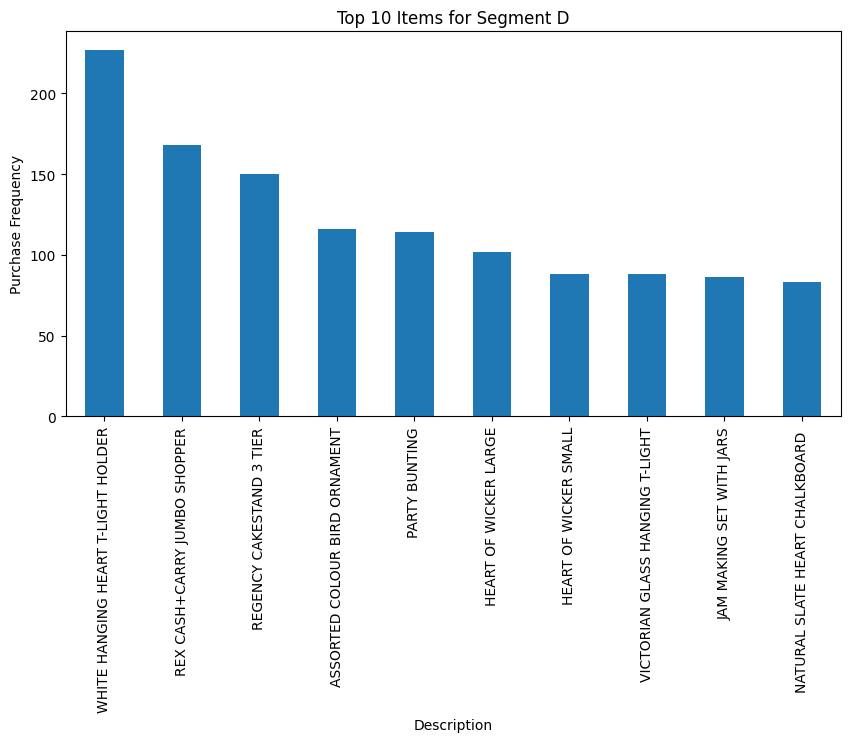

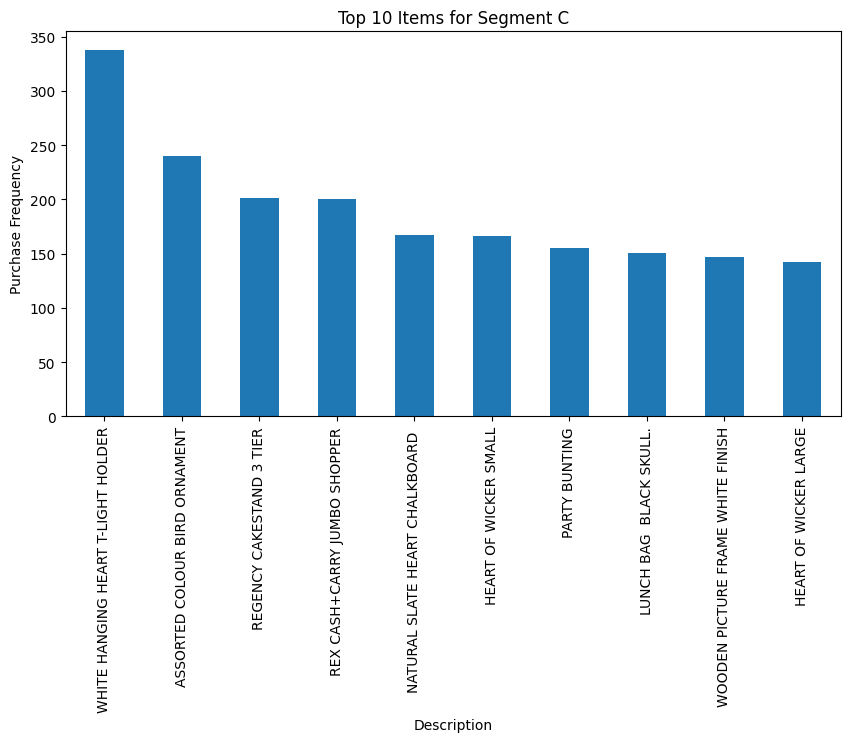

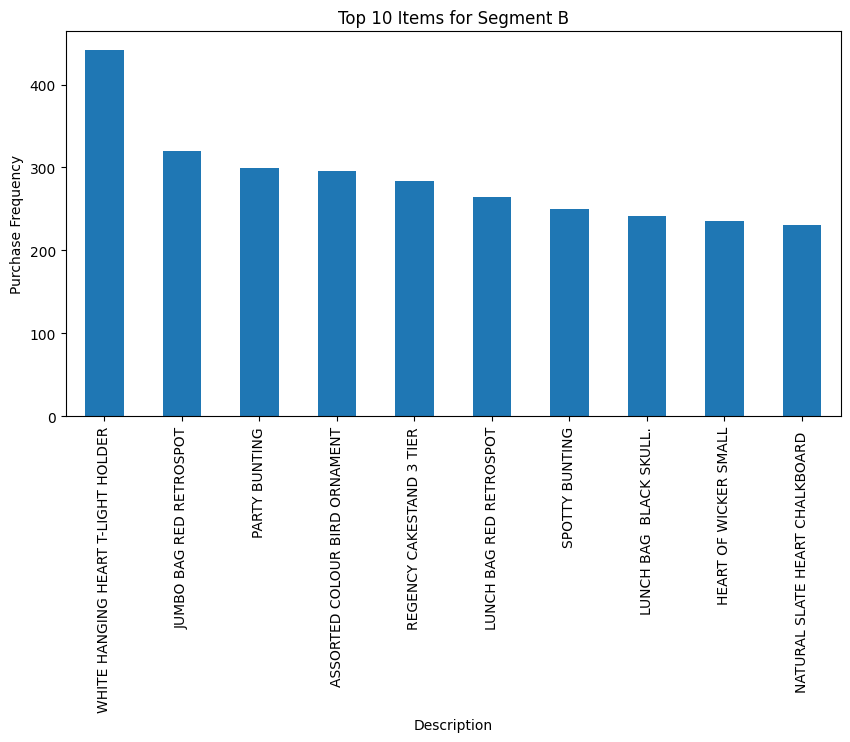

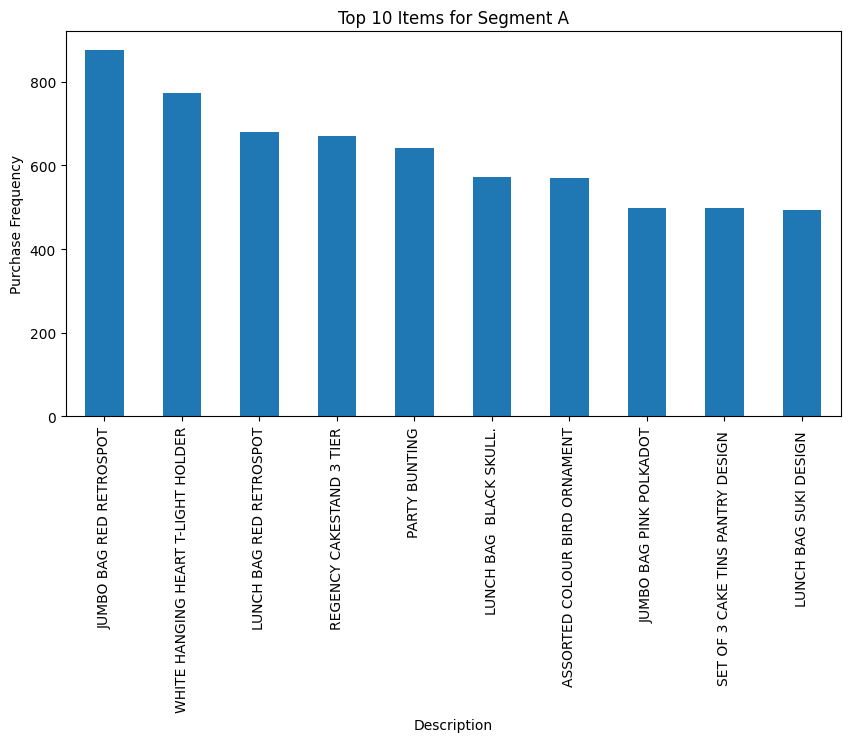

In [15]:
# Reset the index of cltv_final
cltv_final_reset = cltv_final.reset_index()

# Merge segment data back into the original dataframe
df_final = pd.merge(df, cltv_final_reset[['CustomerID', 'Segment']], on='CustomerID')

# Get item frequencies per segment
segment_item_counts = df_final.groupby('Segment')['Description'].value_counts().unstack().fillna(0)

# Get the top N items per segment
top_N = 10
top_items_per_segment = segment_item_counts.apply(lambda x: x.nlargest(top_N).index, axis=1)

# Plot top items for each segment
for segment in top_items_per_segment.index:
    top_items = top_items_per_segment.loc[segment]
    item_frequencies = segment_item_counts.loc[segment, top_items]
    
    plt.figure(figsize=(10, 5))
    item_frequencies.plot(kind='bar')
    plt.title(f'Top {top_N} Items for Segment {segment}')
    plt.ylabel('Purchase Frequency')
    plt.show()


##### 2. Average and Total CLV per Segment

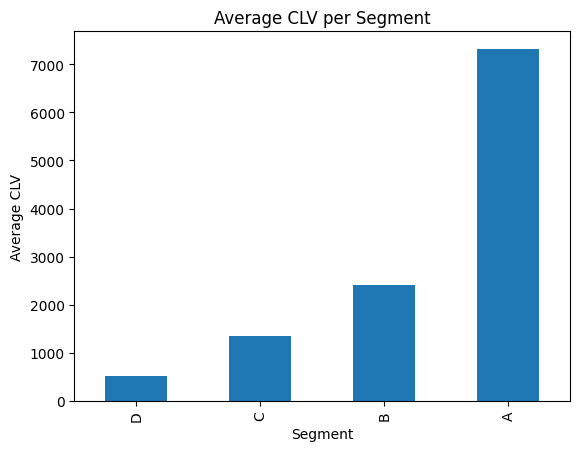

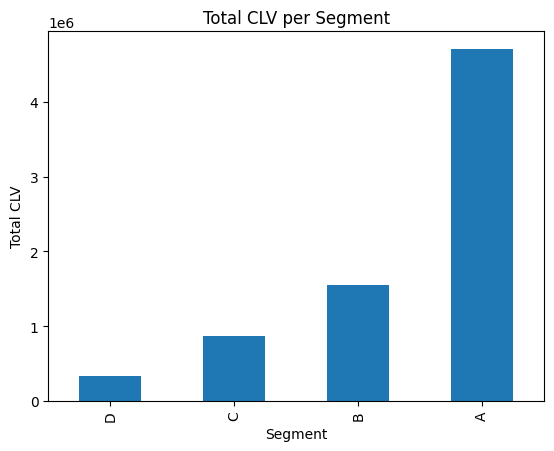

In [16]:
average_clv_per_segment = cltv_final.groupby("Segment")["clv"].mean()
average_clv_per_segment.plot(kind='bar')
plt.title("Average CLV per Segment")
plt.ylabel("Average CLV")
plt.show()

total_clv_per_segment = cltv_final.groupby("Segment")["clv"].sum()
total_clv_per_segment.plot(kind='bar')
plt.title("Total CLV per Segment")
plt.ylabel("Total CLV")
plt.show()

##### 3. Sales Over Time per Segment

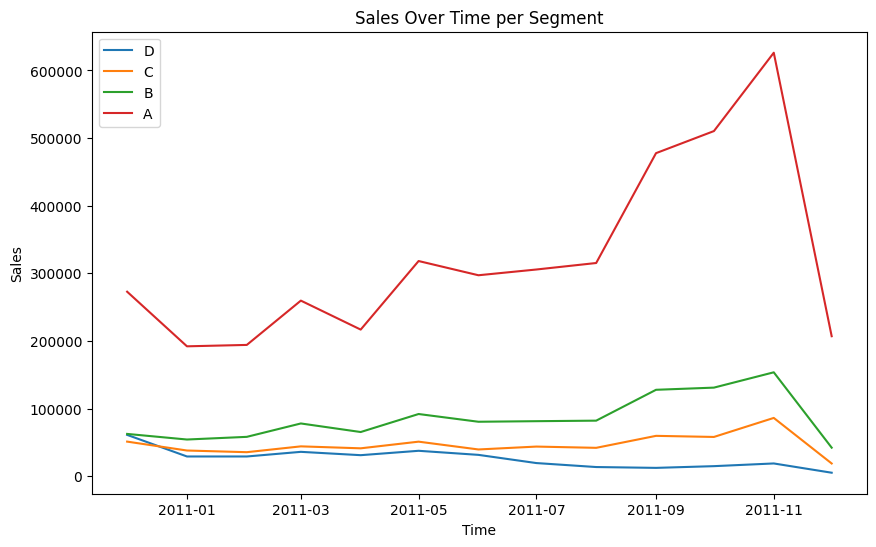

In [17]:
import seaborn as sns

# Ensure 'InvoiceDate' is in datetime format
df_final['InvoiceDate'] = pd.to_datetime(df_final['InvoiceDate'])

# Create 'Sales' column
df_final['Sales'] = df_final['Quantity'] * df_final['UnitPrice']

# Group by 'InvoiceDate' and 'Segment'
sales_over_time_per_segment = df_final.groupby([df_final['InvoiceDate'].dt.to_period("M"), 'Segment'])['Sales'].sum().reset_index()
sales_over_time_per_segment['InvoiceDate'] = sales_over_time_per_segment['InvoiceDate'].dt.to_timestamp()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x='InvoiceDate', y='Sales', hue='Segment', data=sales_over_time_per_segment)
plt.title("Sales Over Time per Segment")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.legend(loc='upper left')
plt.show()


##### 4. Correlation between Frequency, Monetary Value, and Recency

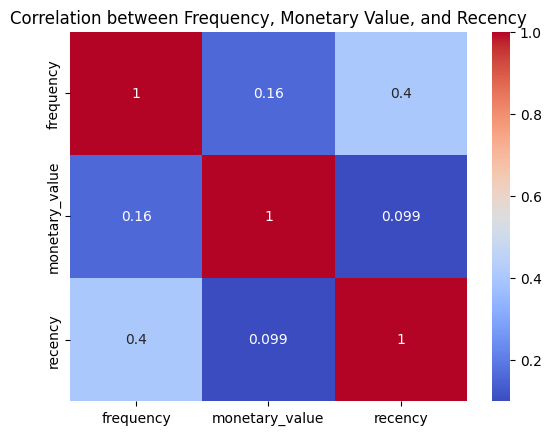

In [18]:
correlation = cltv_final[['frequency', 'monetary_value', 'recency']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation between Frequency, Monetary Value, and Recency")
plt.show()
